# Goal of the project

The main goal of this project is to predict the 10-year risk of Coronary Heart Disease (CHD) using logistic regression based on lifestyle and medical features.

## Objectives
- Preprocess and clean the dataset by handling missing values and encoding categorical features.
- Perform Exploratory Data Analysis (EDA) to understand key patterns and distributions.
- Train a logistic regression model to predict the likelihood of CHD occurrence.
- Evaluate model performance using appropriate classification metrics and determine the optimal decision threshold for classification.
- Interpret the results and provide data-driven insights for CHD risk factors.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from statsmodels.tools.tools import add_constant
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

#### Utility Functions <!-- collapse -->

In [2]:
def train_model(X_train, y_train, threshold=0.5):
    """
    Train a logistic regression model with standard scaling and evaluate performance on the training set.

    Steps:
        - Standardize feature values using StandardScaler.
        - Train a Logistic Regression model with balanced class weights.
        - Predict class probabilities and apply threshold to generate binary predictions.
        - Evaluate model performance using AUC, Precision, Recall, and F1 Score.
        - Display a confusion matrix and ROC curve for visual interpretation.

    Parameters:
        X_train (DataFrame or ndarray): Feature matrix for training.
        y_train (Series or ndarray): Target labels for training.
        threshold (float): Decision threshold for converting probabilities to class labels (default = 0.5).

    Returns:
        dict: A dictionary containing:
            - 'model' (LogisticRegression): Trained logistic regression model.
            - 'scaler' (StandardScaler): Fitted scaler used for feature normalization.
            - 'X_train_scaled' (ndarray): Scaled training features.
            - 'y_train' (array): True training labels.
            - 'y_pred' (array): Predicted class labels.
            - 'y_probs' (array): Predicted probabilities for class 1.
            - 'auc' (float): Area Under the ROC Curve score.
            - 'precision' (float): Precision score.
            - 'recall' (float): Recall score.
            - 'f1_score' (float): F1 score.
            - 'confusion_matrix' (ndarray): Confusion matrix of predictions.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LogisticRegression(class_weight="balanced", max_iter=1000)
    model.fit(X_train_scaled, y_train)

    y_probs = model.predict_proba(X_train_scaled)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    auc = roc_auc_score(y_train, y_probs)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    cm = confusion_matrix(y_train, y_pred)

    print("Training Evaluation Metrics:")
    print(f"Threshold     : {threshold:.2f}")
    print(f"AUC Score     : {auc:.4f}")
    print(f"Precision     : {precision:.4f}")
    print(f"Recall        : {recall:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No CHD", "CHD"],
                yticklabels=["No CHD", "CHD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix on Training Data")
    plt.show()

    fpr, tpr, _ = roc_curve(y_train, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Training Data")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "model": model,
        "scaler": scaler,
        "X_train_scaled": X_train_scaled,
        "y_train": y_train,
        "y_pred": y_pred,
        "y_probs": y_probs,
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
    }


def evaluate_model(model, scaler, X_test, y_test, threshold=0.5):
    """
    Evaluate a trained model on test data, displaying metrics and visualizations.

    Steps:
        - Scale test data using the pre-fitted StandardScaler.
        - Generate class probabilities and predictions based on a specified threshold.
        - Calculate evaluation metrics including AUC, Precision, Recall, and F1 Score.
        - Display a confusion matrix heatmap for classification performance.
        - Plot the ROC curve to visualize the trade-off between sensitivity and specificity.

    Parameters:
        model (LogisticRegression): Trained logistic regression model.
        scaler (StandardScaler): Fitted scaler used for transforming feature values.
        X_test (DataFrame or ndarray): Feature matrix for testing.
        y_test (Series or ndarray): True labels for the test set.
        threshold (float): Decision threshold for converting probabilities into class predictions (default = 0.5).

    Returns:
        dict: A dictionary containing:
            - 'X_test_scaled' (ndarray): Scaled test features.
            - 'y_test' (array): True test labels.
            - 'y_pred' (array): Predicted class labels.
            - 'y_probs' (array): Predicted probabilities for class 1.
            - 'auc' (float): Area Under the ROC Curve score.
            - 'precision' (float): Precision score.
            - 'recall' (float): Recall score.
            - 'f1_score' (float): F1 score.
            - 'confusion_matrix' (ndarray): Confusion matrix of predictions.
    """
    X_test_scaled = scaler.transform(X_test)

    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_probs)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("Test Evaluation Metrics:")
    print(f"Threshold     : {threshold:.2f}")
    print(f"AUC Score     : {auc:.4f}")
    print(f"Precision     : {precision:.4f}")
    print(f"Recall        : {recall:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No CHD", "CHD"],
                yticklabels=["No CHD", "CHD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix on Test Data (Threshold = {threshold:.2f})")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Test Data")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "X_test_scaled": X_test_scaled,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_probs": y_probs,
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
    }

def cross_validate_model(X, y, n_splits=5, threshold=0.5, random_state=42, verbose=True):
    """
    Perform k-fold cross-validation with logistic regression and standard scaling.

    Parameters:
        X (DataFrame): Feature data
        y (Series): Target variable
        n_splits (int): Number of cross-validation folds
        threshold (float): Threshold for classification
        random_state (int): Seed for reproducibility
        verbose (bool): Print average metrics at the end

    Returns:
        dict: Dictionary of average metrics
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    aucs, f1s, precisions, recalls = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        model = LogisticRegression(class_weight="balanced", max_iter=1000)
        model.fit(X_train_scaled, y_train)

        y_probs = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)

        aucs.append(roc_auc_score(y_val, y_probs))
        f1s.append(f1_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

        if verbose:
            print(f"Fold {fold}: AUC={aucs[-1]:.4f}, F1={f1s[-1]:.4f}, Precision={precisions[-1]:.4f}, Recall={recalls[-1]:.4f}")

    avg_results = {
        "AUC": np.mean(aucs),
        "F1": np.mean(f1s),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }

    if verbose:
        print("\nAverage Cross-Validation Results:")
        for k, v in avg_results.items():
            print(f"{k:10}: {v:.4f}")

    return avg_results

def find_best_threshold(model, X_scaled, y_true, metric=f1_score, verbose=True):
    """
    Finds the best threshold that maximizes a classification metric (default: F1 score).

    Parameters:
        model: Trained classification model (must support predict_proba)
        X_scaled: Scaled feature matrix (same preprocessing used in training)
        y_true: True labels
        metric: Scoring function (default: f1_score)
        verbose: Whether to print the result

    Returns:
        best_threshold: The threshold that gives the highest score
        best_score: The best score achieved
    """
    y_probs = model.predict_proba(X_scaled)[:, 1]

    thresholds = np.arange(0.0, 1.01, 0.01)
    scores = []

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = metric(y_true, y_pred)
        scores.append(score)

    best_index = np.argmax(scores)
    best_threshold = thresholds[best_index]
    best_score = scores[best_index]

    if verbose:
        print(f"\nBest Threshold: {best_threshold:.2f} with {metric.__name__}: {best_score:.4f}")

    return best_threshold, best_score

In [3]:
# Processing functions

def apply_imputations(df, impute_values):
    """
    Applies predefined imputation values to a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame to impute (e.g., test_df)
        impute_values (dict): A dictionary with {column: value} pairs

    Returns:
        DataFrame: A copy of the DataFrame with imputed values
    """
    df_copy = df.copy()
    for col, value in impute_values.items():
        df_copy[col] = df_copy[col].fillna(value)
    return df_copy

In [36]:
# Functions to keep this notebooks clean

def calculate_vif(df, features):
    """
    Calculates VIF for a list of features.
    
    Parameters:
        df (DataFrame): DataFrame containing the features
        features (list): List of feature names to include
    
    Returns:
        DataFrame: VIF values per feature
    """
    X = add_constant(df[features])
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def plot_target_distribution(df, target_col="TenYearCHD", labels=("No CHD", "CHD"), palette="coolwarm"):
    """
    Plots the count distribution of a binary target variable, with percentage labels inside the bars.

    Parameters:
        df (DataFrame): The DataFrame containing the target column
        target_col (str): The name of the binary target column
        labels (tuple): Tuple of class labels (e.g., ("Negative", "Positive"))
        palette (str or list): Color palette for the bars

    Returns:
        None (displays plot)
    """
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=df[target_col], hue=df[target_col], palette=palette, legend=False)

    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total
        ax.annotate(f'{percentage:.2f}%', 
                    (p.get_x() + p.get_width() / 2., count / 2),
                    ha='center', va='center', 
                    fontsize=12, fontweight="bold", color="black")

    plt.title("Distribution of CHD Risk (Target Variable)")
    plt.xlabel("")
    plt.ylabel("")

    plt.legend(labels, title="CHD Status", loc="upper right")
    plt.tight_layout()
    plt.show()



def plot_gender_chd_pie(df, gender_col="sex", target_col="TenYearCHD"):
    """
    Plots three pie charts:
    1. Overall gender distribution
    2. CHD distribution in females
    3. CHD distribution in males

    Parameters:
        df (DataFrame): DataFrame containing the gender and target columns
        gender_col (str): Column name for gender (0 = Female, 1 = Male)
        target_col (str): Column name for binary target (0 = No CHD, 1 = CHD)
    
    Returns:
        None (displays the plot)
    """

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    gender_counts = df[gender_col].value_counts().sort_index()
    plt.pie(
        gender_counts,
        labels=["Female", "Male"],
        autopct="%1.1f%%",
        colors=['#ffcc99', '#99ff99'],
        startangle=90,
        textprops={'fontsize': 18}
    )
    plt.title("Gender Distribution in Dataset")

    sex_chd_counts = df.groupby(gender_col)[target_col].value_counts().unstack()

    plt.subplot(1, 3, 2)
    plt.pie(
        sex_chd_counts.loc[0],
        labels=["No CHD", "CHD"],
        autopct="%1.1f%%",
        colors=['#66b3ff', '#ff9999'],
        startangle=90,
        textprops={'fontsize': 18}
    )
    plt.title("CHD Distribution in Females")

    plt.subplot(1, 3, 3)
    plt.pie(
        sex_chd_counts.loc[1],
        labels=["No CHD", "CHD"],
        autopct="%1.1f%%",
        colors=['#66b3ff', '#ff9999'],
        startangle=90,
        textprops={'fontsize': 18}
    )
    plt.title("CHD Distribution in Males")


def plot_boxplots_grid(df, num_features, cols=4, rows=2, color="#66b3ff"):
    """
    Plots a grid of boxplots for given numeric features.

    Parameters:
        df (DataFrame): DataFrame containing the features
        num_features (list): List of numeric column names to plot
        cols (int): Number of columns in the subplot grid
        rows (int): Number of rows in the subplot grid
        color (str): Color code for the boxplots

    Returns:
        None (displays the plot)
    """
    total = len(num_features)
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, feature in enumerate(num_features, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(y=df[feature], color=color)
        plt.title(f"Boxplot of {feature}")
        plt.tight_layout()

    plt.show()

def cap_outliers_iqr(df, features, multiplier=1.5, verbose=True):
    """
    Caps outliers in selected numeric features using the IQR method.

    Parameters:
        df (DataFrame): The DataFrame to modify
        features (list): List of column names to cap
        multiplier (float): IQR multiplier (default 1.5)
        verbose (bool): Print how many caps were applied per feature

    Returns:
        DataFrame: Copy of the DataFrame with capped values
    """
    df = df.copy()

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        before_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        
        df[col] = df[col].clip(lower_bound, upper_bound)

        if verbose:
            print(f"{col}: {before_outliers} values capped")

    return df


def analyze_logistic_model(model, X_train):
    """
    Analyzes a trained logistic regression model by:
    - Plotting a heatmap of coefficients
    - Calculating and displaying odds ratios

    Parameters:
        model: Trained logistic regression model
        X_train: DataFrame used to train the model (to get feature names)

    Returns:
        coef_df: DataFrame with feature coefficients
        feature_importance: DataFrame with odds ratios
    """
    feature_names = X_train.columns.tolist()
    coefficients = model.coef_

    coef_df = pd.DataFrame(coefficients, columns=feature_names, index=[""]).T
    coef_df.columns = ["Coefficient"]
    coef_df["Abs_Coeff"] = coef_df["Coefficient"].abs()
    coef_df = coef_df.sort_values("Abs_Coeff", ascending=False)

    plt.figure(figsize=(10, 2))
    sns.heatmap(coef_df[["Coefficient"]].T, annot=True, cmap="coolwarm", center=0,
                linewidths=0.5, fmt=".3f", cbar=False)
    plt.title("Logistic Regression Coefficients Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks([])
    plt.xlabel("")
    plt.show()

    print("Model intercept:", model.intercept_[0])

    odds_ratios = np.exp(model.coef_[0])
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})
    feature_importance = feature_importance.sort_values(by='Odds Ratio', ascending=False)

    print("\nOdds Ratios (exp(coefficients)):")
    print(feature_importance)

    return coef_df, feature_importance

def plot_logistic_coefficients(model, feature_names):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs,
        "Odds Ratio": np.exp(coefs)
    })

    coef_df["abs_coef"] = np.abs(coef_df["Coefficient"])
    coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

    plt.figure(figsize=(10, 2))
    sns.heatmap(
        coef_df_sorted[["Coefficient"]].T,
        annot=np.round(coef_df_sorted["Coefficient"].values, 3).reshape(1, -1),
        cmap="Reds",
        cbar=False,
        xticklabels=coef_df_sorted["Feature"],
        yticklabels=[""],
        linewidths=0.5,
        fmt=".3f"
    )
    plt.title("Logistic Regression Coefficients Heatmap")
    plt.show()

    print(f"\nModel intercept: [{intercept:.6f}]")

    print(coef_df[["Feature", "Odds Ratio"]].sort_values("Odds Ratio", ascending=False).reset_index(drop=True))


def summarize_logistic_model(model, X_train):
    """
    Print intercept, odds ratios, and plot a coefficient heatmap
    for a fitted logistic regression model.
    
    Parameters:
    - model: trained sklearn LogisticRegression object
    - X_train: DataFrame used for training (to get feature names)
    """
    feature_names = X_train.columns
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients,
        "Odds Ratio": np.exp(coefficients)
    }).sort_values(by="Coefficient", ascending=False)

    print(f"\nModel intercept: [{intercept:.6f}]\n")
    print("Odds Ratios:")
    print(coef_df[["Feature", "Odds Ratio"]].round(6).to_string(index=False))

    plt.figure(figsize=(14, len(coef_df) * 0.2))
    sns.heatmap(
        coef_df.set_index("Feature")[["Coefficient"]].T,
        annot=True,
        cmap="coolwarm",
        center=0,
        linecolor="white",
        linewidths=0.5
    )
    plt.title("Logistic Regression Coefficient Heatmap")
    plt.xlabel("")
    plt.ylabel("Weight")
    plt.tight_layout()
    plt.show()


def analyze_false_negatives(X_train, train_results, n=5):
    """
    Identify and display false negatives in the training data.
    
    Parameters:
    - X_train: original training features (DataFrame)
    - train_results: dictionary returned by `train_model()`
    - n: number of top false negatives to display (default = 5)
    
    Returns:
    - DataFrame of all false negatives (sorted by lowest predicted probability)
    """
    
    y_train_true = train_results["y_train"]
    y_train_pred = train_results["y_pred"]
    y_train_probs = train_results["y_probs"]
    
    df_train_results = pd.DataFrame({
        "True_Label": y_train_true,
        "Predicted_Label": y_train_pred,
        "Predicted_Probability": y_train_probs
    })

    df_train_results = pd.concat(
        [X_train.reset_index(drop=True), df_train_results.reset_index(drop=True)],
        axis=1
    )

    false_negatives = df_train_results[
        (df_train_results["True_Label"] == 1) & 
        (df_train_results["Predicted_Label"] == 0)
    ].sort_values(by="Predicted_Probability", ascending=True)

    display(false_negatives.head(n))
    print("False negatives:", len(false_negatives))
    
    return false_negatives

def plot_false_negative_distributions(df_train_results, features_to_plot=None):
    """
    Plots KDE distributions comparing false negatives vs others for selected features.
    
    Parameters:
    - df_train_results: DataFrame that includes original features + True_Label and Predicted_Label
    - features_to_plot: list of feature names to plot (defaults to 8 common risk factors)
    """
    if features_to_plot is None:
        features_to_plot = ["age", "sex", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "glucose"]
    
    train_analysis_df = df_train_results.copy()
    train_analysis_df["is_false_negative"] = (
        (train_analysis_df["True_Label"] == 1) & 
        (train_analysis_df["Predicted_Label"] == 0)
    )
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        sns.kdeplot(
            data=train_analysis_df,
            x=feature,
            hue="is_false_negative",
            fill=True,
            common_norm=False,
            palette=["gray", "red"],
            alpha=0.4,
            ax=axes[i]
        )
        axes[i].set_title(f"{feature} (False Negatives vs Others)")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Density")

    plt.tight_layout()
    plt.show()


def summarize_binary_features(df, binary_features):
    """
    Summarizes counts and percentages of binary features in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the binary features
    - binary_features: list of column names (strings) representing binary features (expected to be 0/1)

    Returns:
    - A pandas DataFrame showing for each feature:
        - Count of 0s and 1s
        - Percentage of 0s and 1s (relative to non-missing values only)
    """
    binary_summary = []

    for feature in binary_features:
        counts = df[feature].value_counts().to_dict()
        total = sum(counts.values())
        binary_summary.append({
            'Feature': feature,
            'Count_0': counts.get(0, 0),
            'Count_1': counts.get(1, 0),
            '%_0': round((counts.get(0, 0) / total) * 100, 2) if total else 0,
            '%_1': round((counts.get(1, 0) / total) * 100, 2) if total else 0
        })

    return pd.DataFrame(binary_summary)

def analyze_numeric_skewness(df, numeric_features):
    """
    Computes skewness for numeric features and plots their distributions.

    Parameters:
    - df: pandas DataFrame containing the data
    - numeric_features: list of numeric feature column names (strings)

    Returns:
    - skew_df: DataFrame with feature names and their skewness values
    """
    skew_values = df[numeric_features].apply(lambda x: skew(x, nan_policy='omit'))
    skew_df = skew_values.reset_index()
    skew_df.columns = ['Feature', 'Skewness']
    
    print("Skewness of Numeric Features:\n")
    print(skew_df)

    plt.figure(figsize=(12, 10))
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[feature].dropna(), kde=True, bins=30, color='blue')
        plt.title(f'{feature} distribution')

    plt.tight_layout()
    plt.show()

    return skew_df

def plot_histograms_by_chd(df, numeric_features, target_col="TenYearCHD"):
    """
    Plots stacked histograms for a list of numeric features, split by CHD status.

    Parameters:
        df (DataFrame): The input dataset
        numeric_features (list): List of numeric feature names to plot
        target_col (str): Binary target column name (default = 'TenYearCHD')

    Returns:
        None (displays the histograms)
    """

    bin_settings = {
        "age": np.arange(30, 75, 5),
        "cigsPerDay": np.arange(0, 75, 7),
        "totChol": np.arange(100, 710, 30),       
        "sysBP": np.arange(80, 310, 12),          
        "diaBP": np.arange(45, 150, 7),           
        "BMI": np.arange(15, 60, 3.5),            
        "heartRate": np.arange(40, 145, 7),      
        "glucose": np.arange(40, 400, 9),        
    }

    palette = ["blue", "red"] 


    rows = (len(numeric_features) + 3) // 4
    fig, axes = plt.subplots(rows, 4, figsize=(22, rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_features):
        bins = bin_settings.get(feature, 10)
        sns.histplot(
            data=df,
            x=feature,
            hue=target_col,
            multiple="stack",
            bins=bins,
            palette=palette,
            ax=axes[i]
        )
        axes[i].set_title(f"{feature} Distribution by CHD Status")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")

        if isinstance(bins, np.ndarray) and len(bins) < 25:
            axes[i].set_xticks(bins[::max(1, len(bins)//6)])

        axes[i].legend(title="CHD Status", labels=["CHD", "No CHD"])


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def compare_missing_vs_overall_stats(df):
    """
    Compare the mean and median of numeric columns that contain missing values 
    versus the entire dataset.
    """
    # Select only numeric columns with missing values
    cols_with_missing = df.columns[df.isnull().any()]
    numeric_missing_cols = df[cols_with_missing].select_dtypes(include='number').columns

    if len(numeric_missing_cols) == 0:
        print("No numeric columns with missing values.")
        return pd.DataFrame()

    missing_rows = df.isnull().any(axis=1)

    overall_means = df[numeric_missing_cols].mean()
    overall_medians = df[numeric_missing_cols].median()

    missing_means = df[missing_rows][numeric_missing_cols].mean()
    missing_medians = df[missing_rows][numeric_missing_cols].median()

    comparison_df = pd.DataFrame({
        "Overall Mean": overall_means,
        "Mean (Missing Rows)": missing_means,
        "Diff (Mean)": (missing_means - overall_means).round(2),
        "Overall Median": overall_medians,
        "Median (Missing Rows)": missing_medians,
        "Diff (Median)": (missing_medians - overall_medians).round(2)
    })

    comparison_df["Abs Diff (Median)"] = comparison_df["Diff (Median)"].abs()
    comparison_df = comparison_df.sort_values(by="Abs Diff (Median)", ascending=False)
    comparison_df.drop(columns="Abs Diff (Median)", inplace=True)

    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    return comparison_df


### Data is downloaded from : https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea

# Data Loading and Cleaning

In [5]:
df = pd.read_csv("train.csv")
df.sample(10)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3269,3269,39,1.0,F,YES,15.0,0.0,0,0,0,255.0,142.0,85.5,24.89,100.0,108.0,0
2658,2658,50,2.0,F,YES,10.0,0.0,0,0,0,220.0,122.0,80.0,24.22,75.0,72.0,0
2358,2358,56,1.0,M,YES,1.0,0.0,0,0,0,280.0,147.0,94.0,28.30,63.0,85.0,0
1811,1811,63,1.0,F,NO,0.0,0.0,0,1,0,293.0,193.0,63.0,30.00,70.0,76.0,1
788,788,38,2.0,M,YES,20.0,0.0,0,0,0,200.0,123.0,85.0,25.63,90.0,84.0,0
1066,1066,51,3.0,M,NO,0.0,0.0,0,1,0,214.0,145.0,92.5,26.09,70.0,NaN,0
3159,3159,68,1.0,M,NO,0.0,0.0,0,1,1,164.0,142.0,85.0,30.28,70.0,120.0,1
3359,3359,56,3.0,M,NO,0.0,0.0,0,0,0,177.0,124.0,77.0,27.81,60.0,88.0,0
3179,3179,40,4.0,M,YES,20.0,0.0,0,0,0,229.0,137.0,85.0,35.20,66.0,55.0,0
2483,2483,61,1.0,M,YES,20.0,0.0,0,0,0,260.0,115.0,79.0,23.65,56.0,78.0,0


### Explanation of each column

- age: Age of the individual.

- sex: Gender of the individual (F = female, M = male).

- is_smoking: Whether the person currently smokes (yes/no).

- cigsPerDay: Number of cigarettes smoked per day.

- BPMeds: Whether the person is on blood pressure medication (0 = no, 1 = yes).

- prevalentStroke: History of stroke (0 = no, 1 = yes).

- prevalentHyp: History of hypertension (high blood pressure, 0 = no, 1 = yes).

- diabetes: Whether the person has diabetes (0 = no, 1 = yes).

- totChol: Total cholesterol level.

- sysBP: Systolic blood pressure (top number in a BP reading).

- diaBP: Diastolic blood pressure (bottom number in a BP reading).

- BMI: Body Mass Index – a measure of body fat based on height and weight.

- heartRate: Resting heart rate.

- glucose: Blood glucose level.

- TenYearCHD: Target variable – whether the person developed CHD in 10 years (0 = no, 1 = yes).
---
- Since the ***'id' column duplicates the index***,and ***'education' is not explain and I would be just guessing the columns values*** I chose to remove them to keep the dataset clean and understandable.

In [6]:
df.drop(columns=["id", "education"], inplace=True)
df.shape

(3390, 15)

---
- Since the ***sex*** and ***is_smoking*** variables are categorical, I converted them into a binary format to make them usable for logistic regression.

In [7]:
df["sex"] = df["sex"].map({"M": 1, "F": 0})
df["is_smoking"] = df["is_smoking"].map({"YES": 1, "NO": 0})

df.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


---
- I moved on to ***reviewing the missing values in the dataset***.

In [8]:
missing_data = df.isnull().sum().to_frame(name='Missing Count')
missing_data['% Missing'] = (missing_data['Missing Count'] / len(df) * 100).round(2)
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('% Missing', ascending=False)

print("Missing Values Summary:\n")
print(missing_data)

Missing Values Summary:

            Missing Count  % Missing
glucose               304       8.97
BPMeds                 44       1.30
totChol                38       1.12
cigsPerDay             22       0.65
BMI                    14       0.41
heartRate               1       0.03


- After calculating that 386 rows (approximately 11.39% of the dataset) contain missing values, I wanted to understand whether these rows differ significantly from the rest of the dataset.

In [37]:
comparison = compare_missing_vs_overall_stats(df)
display(comparison)

,Overall Mean,Mean (Missing Rows),Diff (Mean),Overall Median,Median (Missing Rows),Diff (Median)
glucose,82.09,85.51,3.43,78.00,81.50,3.50
cigsPerDay,9.07,8.99,-0.07,0.00,1.50,1.50
totChol,237.07,235.80,-1.28,234.00,232.50,-1.50
BMI,25.79,25.56,-0.23,25.38,25.09,-0.29
BPMeds,0.03,0.03,-0.00,0.00,0.00,0.00
heartRate,75.98,77.23,1.25,75.00,75.00,0.00


- This comparison helps assess whether the missing data occurs randomly or is associated with specific patterns

---
- Since my goal is to first run a baseline model without any changes - meaning no feature engineering or imputations - I need to work with the raw dataset as closely as possible. However, in order to train a logistic regression model, it's necessary to remove rows with missing values. Therefore, I apply only the minimal required change: dropping rows with missing data.

- To ensure I can still build enhanced models later (with imputation and feature engineering), I create a copy of the original dataset before making any modifications.

In [10]:
df_baseline = df.copy()
df_processed = df.copy()

In [11]:
initial_rows = len(df_baseline)
df_baseline = df.dropna()
final_rows = len(df_baseline)

dropped_rows = initial_rows - final_rows
dropped_percent = round((dropped_rows / initial_rows) * 100, 2)

print(f"\nDropped {dropped_rows} rows with missing values ({dropped_percent}% of the dataset).")


Dropped 386 rows with missing values (11.39% of the dataset).


# Exploratory data analysis

- I decided to ***examine the balance of binary features between positive and negative occurrences *(Excluding the target variable ('TenYearCHD') from this summary since I will investigate it more in-depth later)***.

In [39]:
binary_features = ["sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
binary_df = summarize_binary_features(df_baseline, binary_features)

display(binary_df)

,Feature,Count_0,Count_1,%_0,%_1
0,sex,1657,1347,55.16,44.84
1,is_smoking,1524,1480,50.73,49.27
2,BPMeds,2913,91,96.97,3.03
3,prevalentStroke,2986,18,99.40,0.60
4,prevalentHyp,2058,946,68.51,31.49
5,diabetes,2922,82,97.27,2.73


- I noticed that ***several binary features*** in the dataset are ***heavily imbalanced, particularly prevalentStroke, BPMeds, and diabetes,*** which have very few positive cases. This could ***reduce their influence in the logistic regression model*** unless they are strong predictors. In contrast, features like is_smoking and sex are well balanced.
---
- To gain better insight into the structure of the data, I examined the distribution and skewness of the numerical features to identify potential outliers and assess the need for transformations.

Skewness of Numeric Features:

      Feature  Skewness
0         age      0.22
1  cigsPerDay      1.21
2     totChol      0.98
3       sysBP      1.18
4       diaBP      0.70
5         BMI      1.03
6   heartRate      0.70
7     glucose      6.17


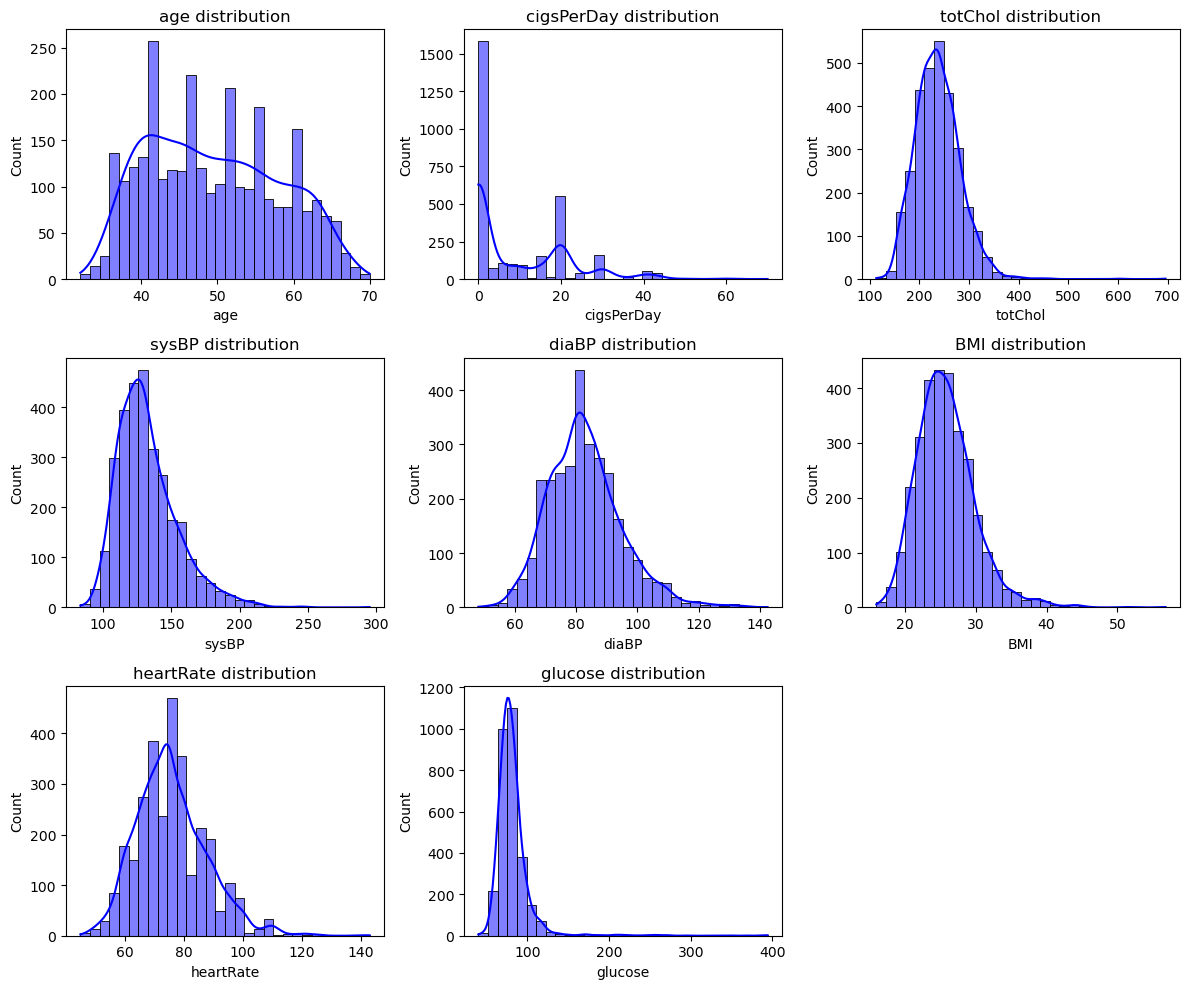

In [13]:
numeric_features = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]
skew_df = analyze_numeric_skewness(df_baseline, numeric_features)

- By checking the skewness of numerical features, I observed that ***most variables have some level of right skew.*** In ***particular, glucose shows a very high skewness (6.17), followed by cigsPerDay (1.29) and sysBP (1.18)***, indicating strong positive skew and potential outliers or long tails toward higher values. Other features like totChol, BMI, and diaBP are moderately skewed, while age and heartRate are closer to a normal distribution. This suggests that transformations such as log or square root may be useful during feature engineering to reduce skewness and improve model performance.
---
- To ***understand relationships between numerical features***, I created a correlation heatmap.

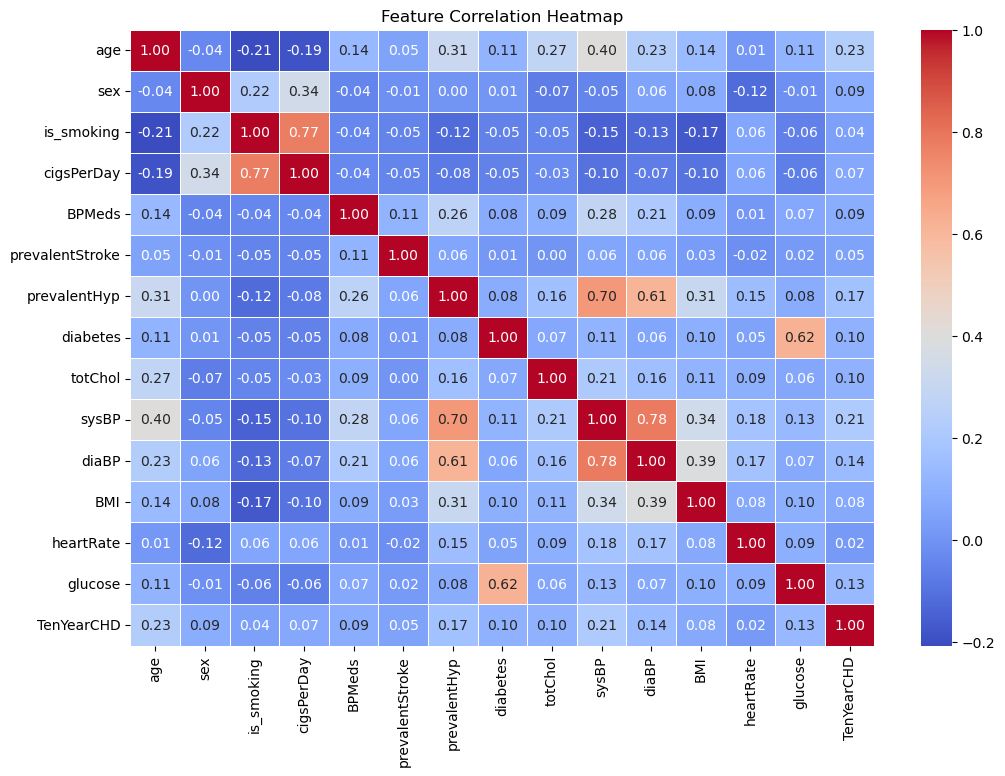

In [14]:
corr_matrix = df_baseline.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

- The highest correlation with TenYearCHD is around 0.23 (age).  
  This suggests that ***no single feature is a strong predictor*** - I need multiple weak predictors  
  working together in the model
---
- I ***computed VIF on the data to check for multicollinearity***, ensuring that no features are overly correlated, which could negatively impact my logistic regression model's stability.

In [15]:
features = [
    "age", "sex", "is_smoking", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"
]

vif_df = calculate_vif(df_baseline, features)
print(vif_df.sort_values("VIF", ascending=False))

            Feature    VIF
0             const 177.16
10            sysBP   3.74
11            diaBP   2.91
4        cigsPerDay   2.74
3        is_smoking   2.60
7      prevalentHyp   2.04
14          glucose   1.65
8          diabetes   1.63
1               age   1.34
12              BMI   1.23
2               sex   1.22
5            BPMeds   1.11
9           totChol   1.11
13        heartRate   1.09
6   prevalentStroke   1.02


- After reviewing the correlation heatmap and VIF scores, I don't see any major multicollinearity concerns at this stage. ***Most features are only weakly to moderately correlated, and all VIF values*** (except the constant term) are below the typical threshold of 5. However, a few variables like sysBP, diaBP, and cigsPerDay show moderately higher VIFs, suggesting some linear relationships.

- Based on this, ***I plan to proceed with the baseline model and continue with feature engineering afterward*** to further refine the dataset and potentially improve model performance.


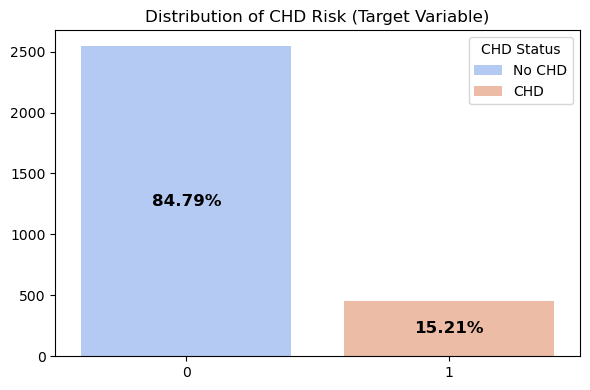

In [16]:
plot_target_distribution(df_baseline)

- Class Imbalance: The ***dataset is highly imbalanced***, with a significantly higher number of individuals without CHD compared to those with CHD.
- Impact on Model Performance: 
  - Since logistic regression assumes a relatively balanced dataset, this ***imbalance may affect the model's predictive performance.***
  - The ***model might be biased*** toward predicting the majority class (no CHD).
  - I may need to ***consider resampling techniques*** (oversampling minority class or undersampling majority class) or use class weighting in logistic regression.

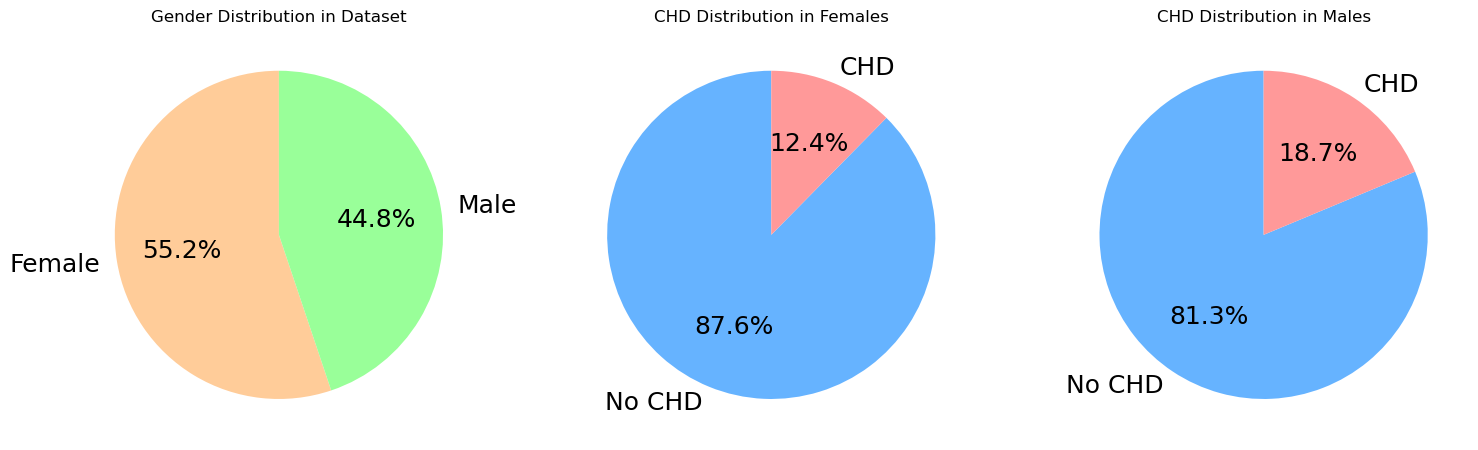

In [17]:
plot_gender_chd_pie(df_baseline)

- The CHD risk is notably higher in males compared to females.
- ***Females show a lower*** proportion of CHD cases, with 88% not having the disease.
- ***Males have a slightly higher CHD risk***
- This ***aligns with known medical research***, where men generally have a higher risk of cardiovascular diseases due to biological and lifestyle factors.

---
- Examining the distribution of CHD across numerical features is useful for identifying potential patterns or trends.

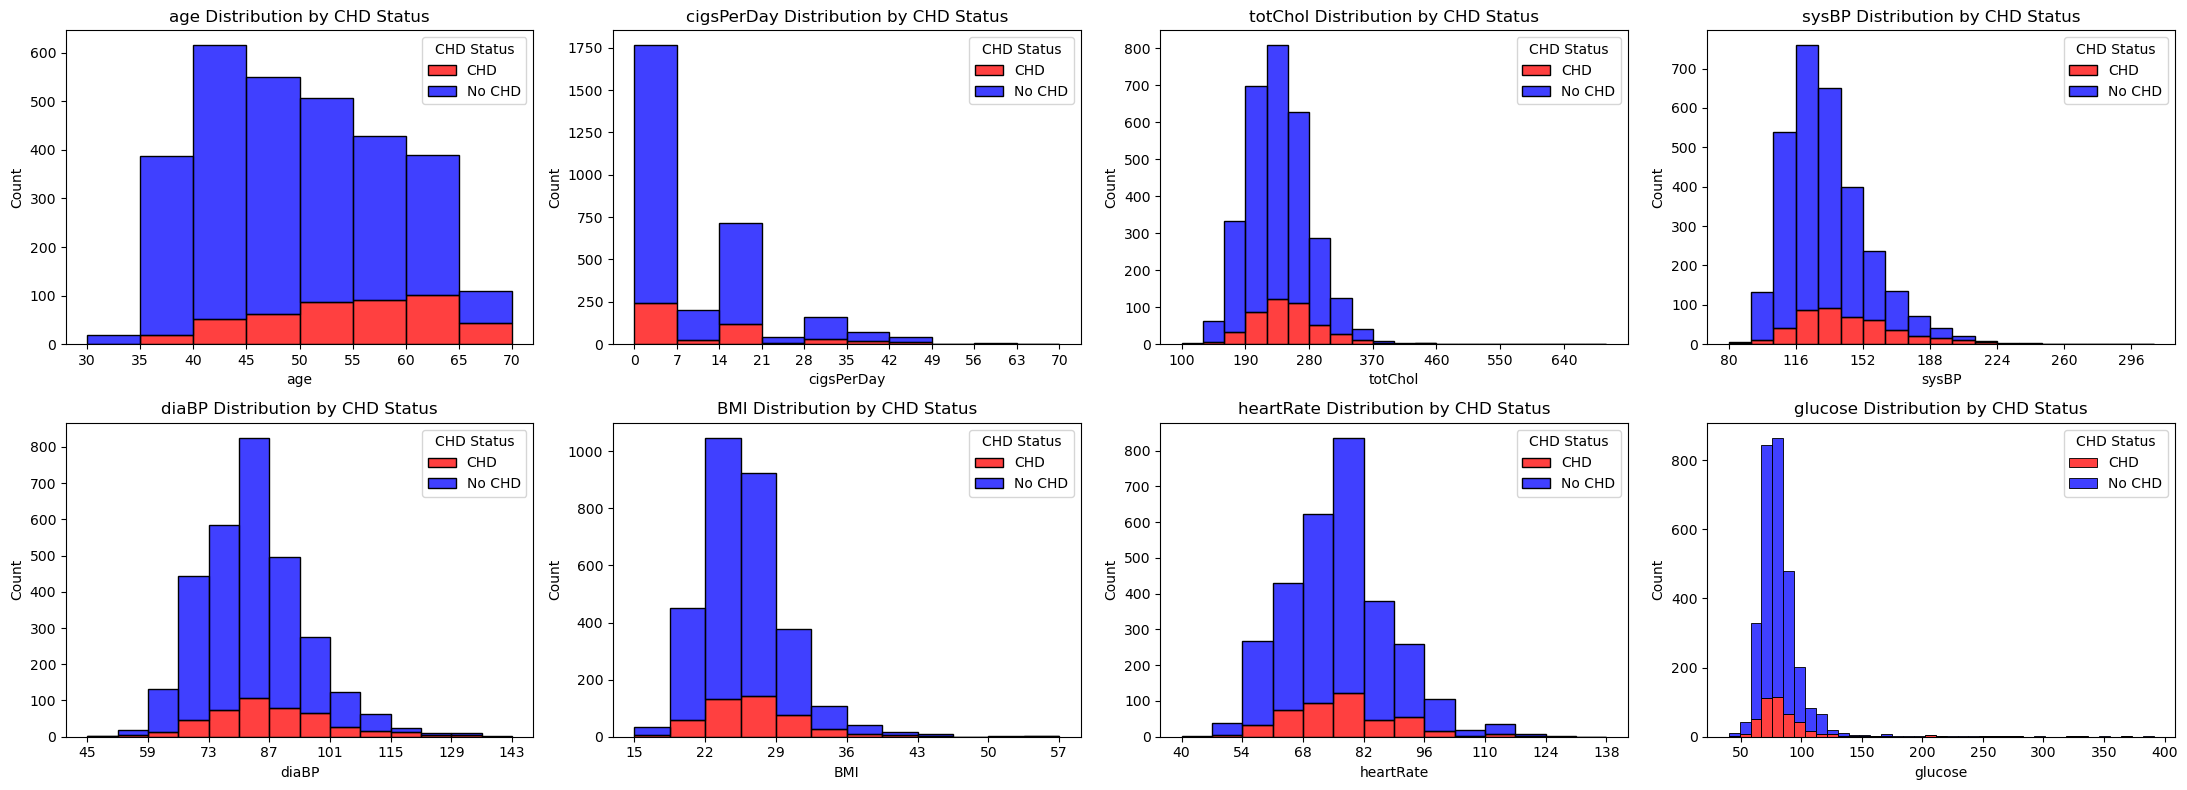

In [18]:
numeric_features = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]
plot_histograms_by_chd(df_baseline, numeric_features)

- Looking at the histograms, I noticed that CHD cases (in red) tend to be more common among individuals with higher age, systolic blood pressure (sysBP), and glucose levels. In contrast, variables like total cholesterol, diastolic BP, BMI, and heart rate appear to have a more similar distribution between CHD and non-CHD groups. Cigarette consumption (cigsPerDay) also shows a skewed distribution with most values clustered at zero, making it harder to distinguish patterns visually. These trends suggest that some features, like age and blood pressure, might be stronger predictors of CHD risk.
---
- Finally, I wanted to ***check for outliers*** in key numeric features

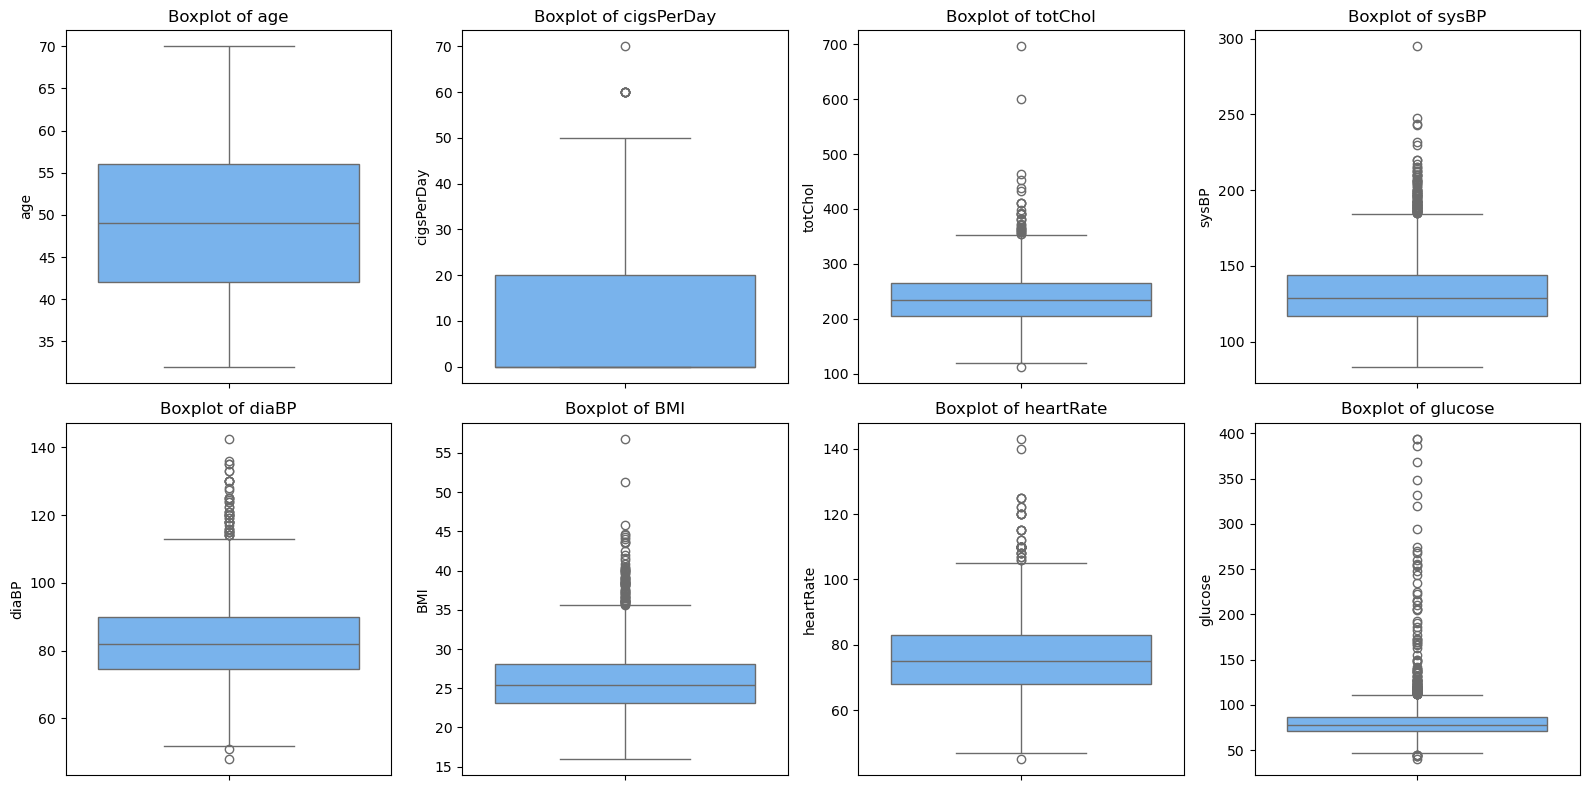

In [19]:
num_features = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]
plot_boxplots_grid(df_baseline, num_features)

- The boxplots reveal ***several features with noticeable outliers. In particular, glucose, totChol, and sysBP*** show a significant number of high-end outliers, suggesting extreme values in the dataset. Other features like BMI, heartRate, cigsPerDay, and diaBP also display moderate outliers above the upper whisker.

# Modeling

### Splitting the data

- Here, I begin the modeling phase by first separating the target variable TenYearCHD from the rest of the dataset. The variable x contains all the predictor features (such as age, blood pressure, cholesterol, etc.), while y holds the corresponding target labels indicating whether coronary heart disease (CHD) occurred within 10 years. I then pass these into the train_model(x, y) function, which automatically splits the data into training and test sets, scales the features using StandardScaler, fits a logistic regression model, and evaluates its performance. The function outputs key metrics such as AUC, precision, recall, and a confusion matrix, helping establish a baseline that I can compare against as I refine the model further

In [20]:
train_df, test_df = train_test_split(df_baseline, test_size=0.2, random_state=42, stratify=df_baseline["TenYearCHD"])

print("Train data:", train_df.shape)
print("\nTest data:", test_df.shape)

Train data: (2403, 15)

Test data: (601, 15)


Fold 1: AUC=0.7142, F1=0.3636, Precision=0.2513, Recall=0.6575
Fold 2: AUC=0.7781, F1=0.4015, Precision=0.2755, Recall=0.7397
Fold 3: AUC=0.7231, F1=0.3665, Precision=0.2599, Recall=0.6216
Fold 4: AUC=0.7264, F1=0.3983, Precision=0.2883, Recall=0.6438
Fold 5: AUC=0.6865, F1=0.3465, Precision=0.2431, Recall=0.6027

Average Cross-Validation Results:
AUC       : 0.7257
F1        : 0.3753
Precision : 0.2636
Recall    : 0.6531


Training Evaluation Metrics:
Threshold     : 0.50
AUC Score     : 0.7357
Precision     : 0.2663
Recall        : 0.6694
F1 Score      : 0.3810


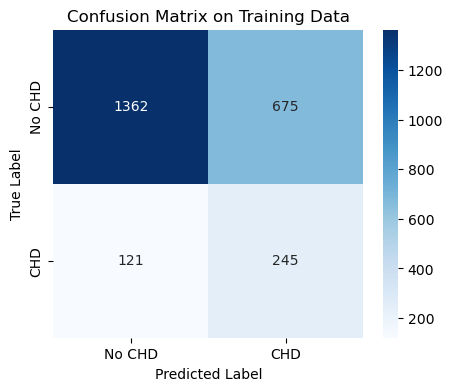

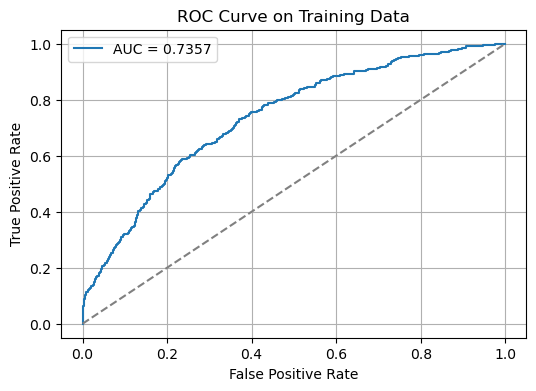

In [21]:
X_base_train = train_df.drop(columns=["TenYearCHD"])
y_base_train = train_df["TenYearCHD"]

cv_results = cross_validate_model(X_base_train, y_base_train, n_splits=5, threshold=0.5)
print("\n")
base_train_results = train_model(X_base_train, y_base_train, threshold=0.5)

---
- Since predicting people’s health is critical, I investigated what causes my model to produce false negatives - cases where CHD is present but not predicted.
I created a dataframe that joins true labels, predictions, and features.
This revealed 121 false negatives, many of whom were younger, had normal glucose or cholesterol, and weren’t on medication — suggesting the model may miss CHD when traditional risk signals are absent.
This analysis helps identify model blind spots and informs future improvements in feature engineering and threshold tuning.

In [22]:
false_negatives = analyze_false_negatives(X_base_train, base_train_results, n=10)

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,True_Label,Predicted_Label,Predicted_Probability
141,35,0,1,20.00,0.00,0,0,0,168.00,83.50,55.00,16.71,79.00,63.00,1,0,0.10
2325,36,0,1,1.00,0.00,0,0,0,160.00,98.00,66.00,25.07,68.00,73.00,1,0,0.12
1142,43,0,0,0.00,0.00,0,0,0,202.00,121.50,86.50,20.82,92.00,77.00,1,0,0.15
419,48,0,0,0.00,0.00,0,0,0,227.00,100.00,76.00,29.45,75.00,67.00,1,0,0.18
353,40,0,0,0.00,0.00,0,0,0,144.00,122.50,80.00,27.46,72.00,123.00,1,0,0.18
393,40,0,1,10.00,0.00,0,0,0,210.00,103.00,71.00,24.40,73.00,68.00,1,0,0.18
604,38,1,0,0.00,0.00,0,0,0,244.00,118.50,88.00,28.68,77.00,65.00,1,0,0.18
1421,42,0,0,0.00,0.00,0,0,0,211.00,134.00,82.00,20.93,75.00,80.00,1,0,0.19
1854,40,1,0,0.00,0.00,0,0,0,161.00,122.00,85.00,30.80,75.00,85.00,1,0,0.20
227,37,0,1,20.00,0.00,0,0,0,166.00,112.00,73.50,21.64,75.00,93.00,1,0,0.20


False negatives: 121


---
- Then I checked the differences between false negatives and the overall training population by comparing their summary statistics.
This helped reveal where the model might be biased — for example, missing CHD in younger individuals or those with normal blood pressure, BMI, or glucose levels.
By subtracting the descriptive stats, I could clearly see which features were consistently lower or higher in the misclassified cases, highlighting areas for potential model improvement.

In [23]:
false_neg_clean = false_negatives.drop(columns=["Predicted_Label", "Predicted_Probability", "True_Label"])
false_neg_desc = false_neg_clean.describe()
train_desc = train_df[false_neg_clean.columns].describe()
diff = false_neg_desc - train_desc
diff

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00,-2282.00
mean,-2.49,-0.07,0.06,0.89,-0.01,-0.01,-0.12,-0.02,0.53,-5.70,-1.47,-0.33,0.13,-5.65
std,-1.54,-0.01,-0.00,-0.47,-0.04,-0.08,-0.07,-0.07,5.02,-4.23,-0.86,-0.06,-1.07,-12.46
min,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,7.00,0.75,10.00,13.00
25%,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,-2.00,1.00,-0.33,0.00,-1.00
50%,-3.00,0.00,1.00,5.00,0.00,0.00,0.00,0.00,1.00,-5.50,-1.00,-0.27,0.00,-2.00
75%,-4.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,3.00,-7.00,-2.00,-0.17,-2.00,-4.00
max,-3.00,0.00,0.00,-27.00,0.00,-1.00,0.00,0.00,0.00,-99.00,-22.50,-16.86,-33.00,-271.00


---
- To better understand where my model fails, I visualized the distribution of key features for cases where it produced false negatives - that is, people who actually have CHD but were predicted as not having it.
I used KDE plots to compare each feature's distribution between false negatives and everyone else in the training data.

- This comparison helps identify subtle feature patterns that may be leading the model to underestimate CHD risk.

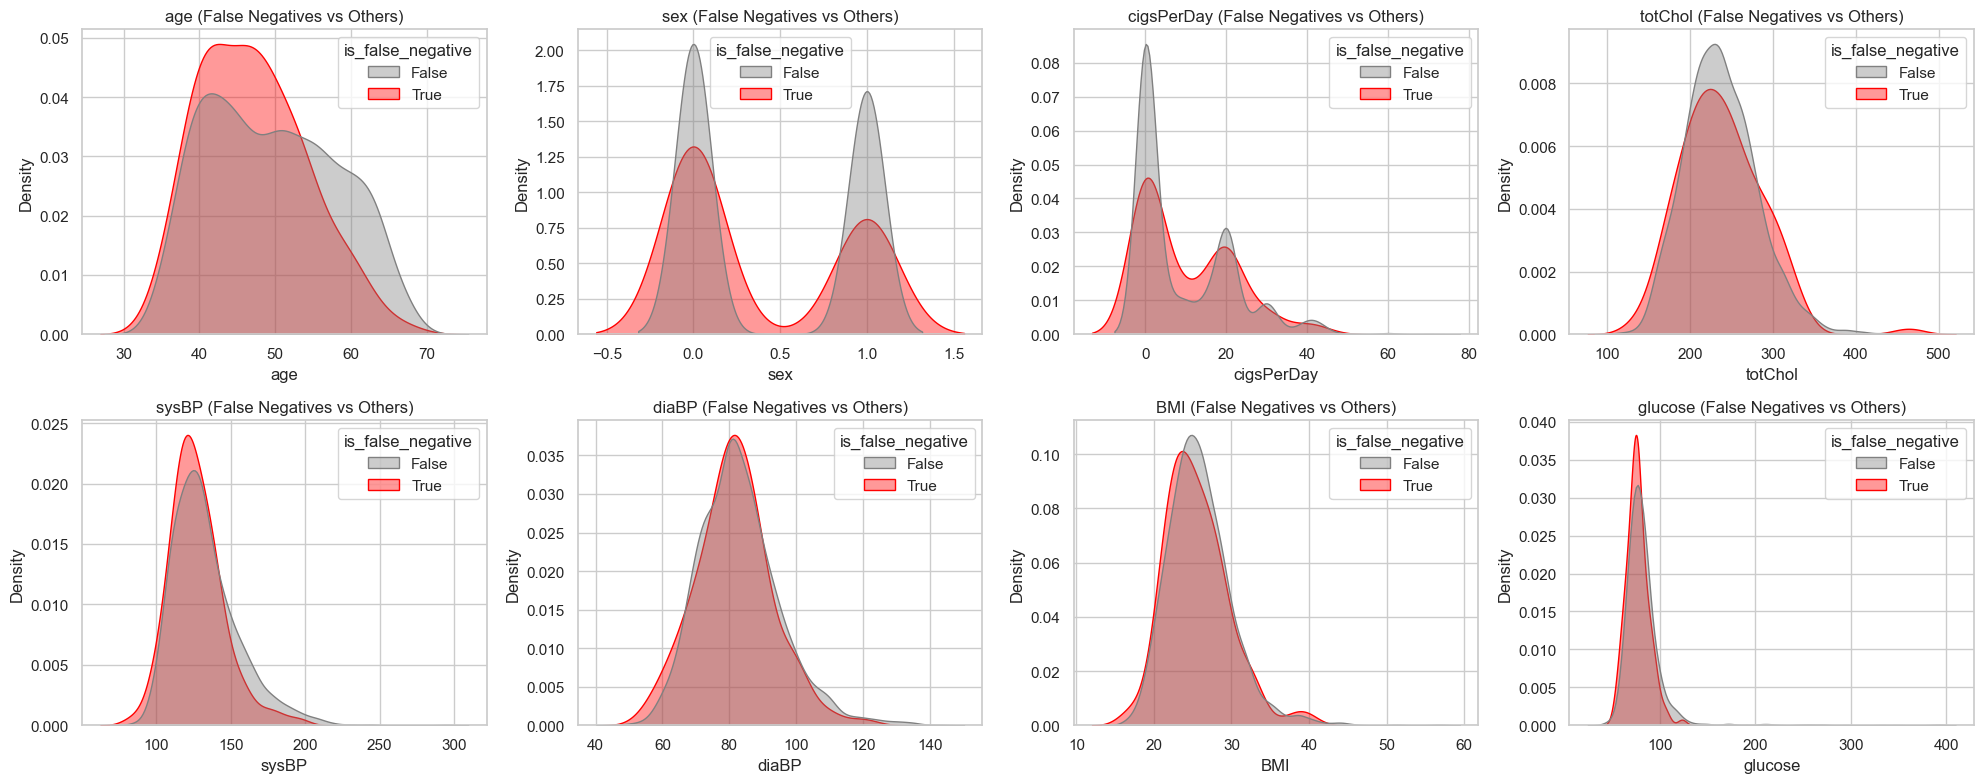

In [24]:
y_train_true = base_train_results["y_train"]
y_train_pred = base_train_results["y_pred"]
y_train_probs = base_train_results["y_probs"]

df_train_results = pd.DataFrame({
    "True_Label": y_train_true,
    "Predicted_Label": y_train_pred,
    "Predicted_Probability": y_train_probs
})

df_train_results = pd.concat(
    [X_base_train.reset_index(drop=True), df_train_results.reset_index(drop=True)],
    axis=1
)

plot_false_negative_distributions(df_train_results)

- Age: False negatives are concentrated in the younger population. The model tends to miss CHD in people under 55.

- Sex: There’s a slight overrepresentation of females among false negatives, possibly suggesting gender bias.

- Cigarettes per Day: Many false negatives are non-smokers or light smokers, showing the model might heavily rely on smoking status.

- Total Cholesterol: Very similar distributions between false negatives and the rest, suggesting cholesterol alone doesn't differentiate false negatives well. This means totChol does not significantly contribute to false negative errors in this prediction task.

- Systolic BP: False negatives are skewed toward lower blood pressure, indicating the model misses CHD in people without hypertension.

- BMI: Very subtle difference; false negatives tend to have slightly lower BMI.

- Glucose: False negatives have slightly lower glucose, again hinting the model underestimates CHD in metabolically “normal” individuals.

---
- And finally, I evaluated how well my base ***model performs on unseen data.***

Test Evaluation Metrics:
Threshold     : 0.50
AUC Score     : 0.7529
Precision     : 0.2819
Recall        : 0.7033
F1 Score      : 0.4025


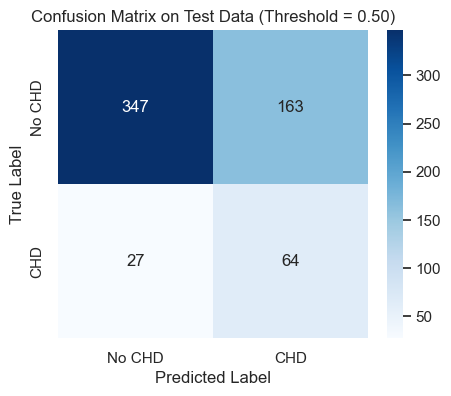

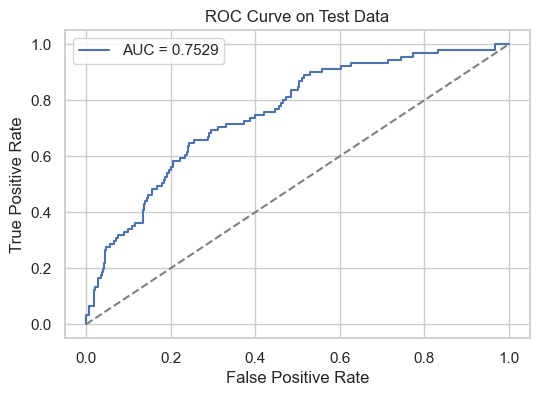

In [25]:
X_test = test_df.drop(columns=["TenYearCHD"])
y_test = test_df["TenYearCHD"]

model = base_train_results["model"]
scaler = base_train_results["scaler"]
base_test_results = evaluate_model(model, scaler, X_test, y_test, threshold=0.5)

# Main model creation

- After completing my exploratory data analysis and reviewing the baseline model's performance, I now move forward with preparing data for the enhanced model. At this stage, I use the copy of the original dataset I created at the beginning (df_processed), which remains completely untouched - meaning no rows were dropped, no missing values were imputed, and no features were engineered yet.

In [26]:
df_processed = df_processed.dropna(subset=["cigsPerDay", "glucose"])

- cigsPerDay: Imputing the median could incorrectly assign smoking values to non-smokers (e.g., turning 0-cigarette users into smokers), which introduces misleading behavior into the model.

- glucose: The missing rows had noticeably higher glucose values (mean: 85.5 vs. 82.1; median: 81.5 vs. 78.0), suggesting that missingness is not random. Dropping them avoids bias that could arise from incorrect imputation.

In [27]:
p_train_df, p_test_df = train_test_split(df_processed, test_size=0.2, random_state=42, stratify=df_processed["TenYearCHD"])

print("Train data:", p_train_df.shape)
print("\nTest data:", p_test_df.shape)

Train data: (2453, 15)

Test data: (614, 15)


---
- BPMeds: Imputed with mode because it's binary/categorical.

- totChol, BMI, heartRate: Imputed with median to reduce skew impact and preserve distribution.

In [28]:
impute_values_train = {
"BPMeds": p_train_df["BPMeds"].mode()[0],
"totChol": p_train_df["totChol"].median(),
"BMI": p_train_df["BMI"].median(),
"heartRate": p_train_df["heartRate"].median(),
}

impute_values_test = {
"BPMeds": p_test_df["BPMeds"].mode()[0],
"totChol": p_test_df["totChol"].median(),
"BMI": p_test_df["BMI"].median(),
"heartRate": p_test_df["heartRate"].median(),
}

p_train_df = apply_imputations(p_train_df, impute_values_train)
p_test_df = apply_imputations(p_test_df, impute_values_test)

---
- As observed earlier, the glucose, sysBP and cigsPerDay features exhibit significant skewness, so addressing this may help improve our model's performance.

In [29]:
p_train_df["cigsPerDay"] = np.log1p(p_train_df["cigsPerDay"])
p_train_df["glucose"] = np.log(p_train_df["glucose"])
p_train_df["sysBP"] = np.log(p_train_df["sysBP"])

p_test_df["cigsPerDay"] = np.log1p(p_test_df["cigsPerDay"])
p_test_df["glucose"] = np.log(p_test_df["glucose"])
p_test_df["sysBP"] = np.log(p_test_df["sysBP"])

---
- To reduce multicollinearity, I performed feature engineering and removed highly imbalanced or redundant features that added limited predictive value.

In [30]:
p_train_df = p_train_df.drop(columns=["diabetes", "is_smoking", "diaBP", "prevalentHyp"])
p_test_df = p_test_df.drop(columns=["diabetes", "is_smoking", "diaBP", "prevalentHyp"])

- diabetes was very imbalanced, and for blood sugar issues it’s better to rely on the continuous "glucose" feature.
- is_smoking was dropped because "cigsPerDay" already contains information for both smokers and non-smokers.
- prevalentHyp and diaBP were both highly correlated with "sysBP", so I decided to keep only "sysBP" as it's the stronger and more predictive blood pressure indicator.

Fold 1: AUC=0.7620, F1=0.3983, Precision=0.2892, Recall=0.6400
Fold 2: AUC=0.7248, F1=0.3661, Precision=0.2770, Recall=0.5395
Fold 3: AUC=0.7338, F1=0.4017, Precision=0.3007, Recall=0.6053
Fold 4: AUC=0.7045, F1=0.3402, Precision=0.2470, Recall=0.5467
Fold 5: AUC=0.7451, F1=0.4017, Precision=0.2956, Recall=0.6267

Average Cross-Validation Results:
AUC       : 0.7340
F1        : 0.3816
Precision : 0.2819
Recall    : 0.5916


Training Evaluation Metrics:
Threshold     : 0.54
AUC Score     : 0.7414
Precision     : 0.2900
Recall        : 0.6101
F1 Score      : 0.3932


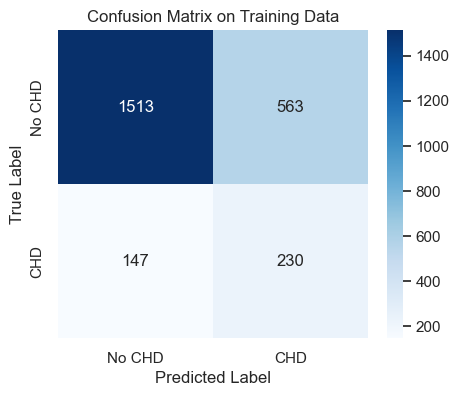

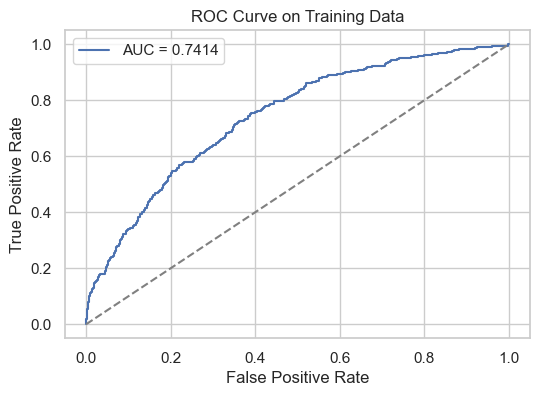

In [31]:
X_p_train = p_train_df.drop(columns=["TenYearCHD"])
y_p_train = p_train_df["TenYearCHD"]

cv_results = cross_validate_model(X_p_train, y_p_train, n_splits=5, threshold=0.54)
print("\n")
processed_train_results = train_model(X_p_train, y_p_train, threshold=0.54)

-  AUC Score improved slightly from 0.7357 → 0.7414, indicating a more discriminative model.
-  F1 Score increased from 0.3810 → 0.3932, suggesting better balance between precision and recall.
-  Precision improved from 0.2663 → 0.2900, meaning fewer false positives.
-  Although recall dropped slightly (0.6694 → 0.6101), it still remains solid, and the tradeoff for higher precision and F1 is reasonable.

---
- To better understand how my logistic regression model makes predictions, I created a summary that includes:

    - The model intercept, which represents the log-odds of CHD when all features are zero.

    - A table of odds ratios for each feature, which indicates how a one-unit increase in that feature affects the odds of CHD.

    - A heatmap of the model’s coefficients to visually compare feature importance and direction of influence.


Model intercept: [-0.288534]

Odds Ratios:
        Feature  Odds Ratio
            age        1.79
     cigsPerDay        1.45
          sysBP        1.43
        totChol        1.21
            sex        1.17
        glucose        1.13
prevalentStroke        1.11
            BMI        1.06
         BPMeds        1.06
      heartRate        0.95


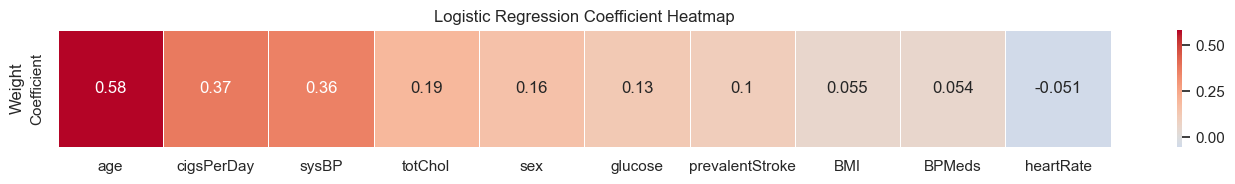

In [32]:
model = processed_train_results["model"]
summarize_logistic_model(model, X_p_train)

---
- Finally, running my final model with unseen data

Test Evaluation Metrics:
Threshold     : 0.54
AUC Score     : 0.7389
Precision     : 0.2864
Recall        : 0.6277
F1 Score      : 0.3933


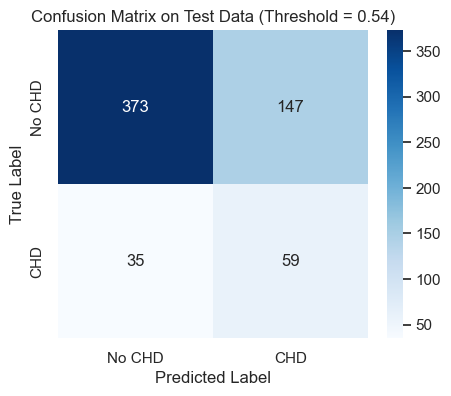

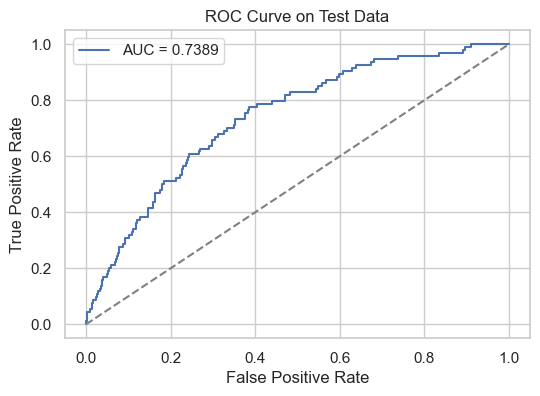

In [33]:
X_p_test = p_test_df.drop(columns=["TenYearCHD"])
y_p_test = p_test_df["TenYearCHD"]

model = processed_train_results["model"]
scaler = processed_train_results["scaler"]
processed_train_results = evaluate_model(model, scaler, X_p_test, y_p_test, threshold=0.54)

# Final Conclusion & Key Insights
### Conclusion
- In this project, I built a logistic regression model to predict 10-year coronary heart disease (CHD) risk using clinical and lifestyle data. After careful preprocessing, feature engineering, cross-validation, and performance evaluation, the model demonstrated reasonable discriminative power, achieving a cross-validated AUC of approximately 0.73–0.74.

- Key preprocessing steps included:
    - Correcting skewness

    - Imputing missing values using medians (except for cigsPerDay and glucose, which were dropped to avoid introducing noise).

    - Reducing multicollinearity by removing highly correlated and imbalanced features.
 
### Key Insights
- Age is the strongest predictor of CHD, especially in older groups
- Blood pressure (sysBP) and cigarette use (cigsPerDay) also had strong positive associations with CHD.
- Total cholesterol (totChol), sex, and glucose had moderate predictive value.
- Cross-validation confirmed the model generalizes reasonably well, with consistent AUC and recall scores across folds.